### Import functions and modules

In [24]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import welch
from scipy.signal import spectrogram
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.signal import square
import numpy as np
from getrpm import getrpm, maketime
from Fast_Kurtogram_Python import Fast_Kurtogram, Feature, max_IJ, K_wpQ, K_wpQ_local, DBFB, TBFB
import scipy.io
import sympy as sp
from scipy import signal
import scipy.signal as Sig
from scipy import integrate

### Part a)

In [3]:
def nextpow2(x):
    res = np.ceil(np.log2(x))
    return res.astype('int')

def get_F_response(t, speed,w_hist):
    grad = speed /4
    w_vals = []
    rpm_vals = []
    if t >= 0 and t<4:
        rpm = grad*t
        w = (2*np.pi*rpm)/60
        w_vals.append(w)
        rpm_vals.append(rpm)
    if t >=4 and t <6:
        rpm = speed
        w = (2*np.pi*rpm)/60
        w_vals.append(w)
        rpm_vals.append(rpm)
    grad = speed /8
    if t >=6 and t <=14:
        rpm = -grad*(t -6) + speed
        w = (2*np.pi*rpm)/60
        w_vals.append(w)
        rpm_vals.append(rpm)
    if t >14:
        rpm = 0
        w = (2*np.pi*rpm)/60
        w_vals.append(w)
        rpm_vals.append(rpm)
        
    # ##################################################################################
    # ######################### Calculating Force Response ############################
    # ##################################################################################
    time = np.linspace(0,t,len(w_hist))
    F = 0
    w_int = integrate.simps(w_hist, time)
    for n in range(1,4+1) :
        F = F + mu*(w**2)*ru*np.sin(n*w_int)
    return F,w_vals , rpm_vals



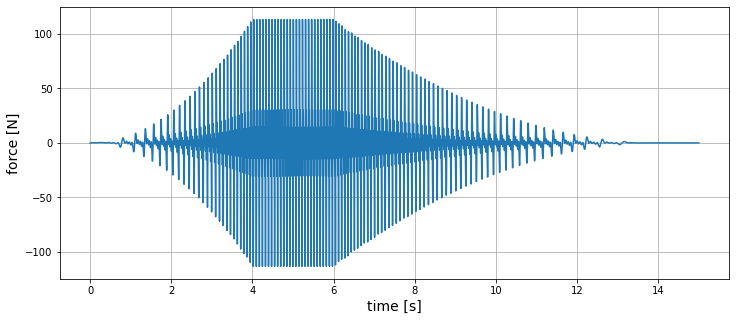

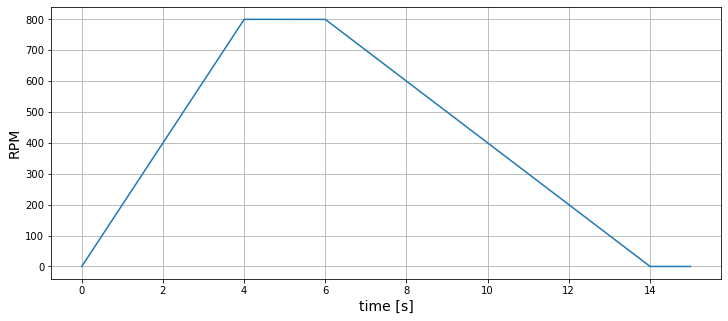

Wall time: 6.9 s


In [21]:
%%time
# constants 
mu = 0.05
ru = 0.1
rpm_buildup = 800
time_steps = 10000


time = np.linspace(0,15,time_steps)

w_vals = [0]
rpm_vals = []
F1 = []
for i in time:
    F,w_vals1 ,rpm_val1s = get_F_response(i,rpm_buildup,w_vals)
    w_vals.append(w_vals1[0])
    rpm_vals.append(rpm_val1s[0])
    F1.append(F)

plt.figure(figsize=(12,5))
plt.plot(time,F1)
plt.xlabel('time [s]',size=14)
plt.ylabel('force [N]',size=14)
plt.grid()
plt.savefig('q1_forcing1.png',dpi=300)
plt.show()


plt.figure(figsize=(12,5))
plt.plot(time,rpm_vals)
plt.xlabel('time [s]',size=14)
plt.ylabel('RPM',size=14)
plt.grid()
plt.savefig('q1_rpm_1.png',dpi=300)
plt.show()

In [5]:
# Same cell as forcing function:

def dz1_dt(t, z1, z2, speed):
    # Parametrizing Velocity
    return z2

def dz2_dt(t, z1, z2, speed, F):
    return (-c*z2 - k*z1 + F)/m

def Runge_kutta(speed):
    t = 0
    i = 0
    z1 = 0
    z2 = 0

    z1_vals = []
    z2_vals = []
    t_vals = []
    w_vals = [0]
    
    
    while t >= ti and t <= tf:
        F,w_vals1 ,rpm_val1s = get_F_response(t, speed, w_vals)
        w_vals.append(w_vals1[0])
        K1z1 = dz1_dt(t,z1 ,z2 , speed )
        K1z2 = dz2_dt(t,z1 ,z2 , speed, F)
        K2z1 = dz1_dt(t+h/2, z1 + h /2* K1z1, z2 + h /2* K1z2, speed)
        K2z2 = dz2_dt(t+h/2, z1 + h /2* K1z1, z2 + h /2* K1z2, speed, F)
        K3z1 = dz1_dt(t+h/2, z1 + h /2* K2z1, z2 + h /2* K2z2, speed)
        K3z2 = dz2_dt(t+h/2, z1 + h /2* K2z1, z2 + h /2* K2z2, speed, F)
        K4z1 = dz1_dt(t+h, z1 + h * K3z1, z2 + h *K3z2, speed)
        K4z2 = dz2_dt(t+h, z1 + h * K3z1, z2 + h *K3z2, speed, F)

        z1_vals.append(z1)
        z2_vals.append(z2)
        t_vals.append(t)

        z1 = z1 + h/6*(K1z1 + 2 * K2z1 + 2 * K3z1 + K4z1)
        z2 = z2 + h/6*(K1z2 + 2 * K2z2 + 2 * K3z2 + K4z2)

        i = i + 1
        t = t + h
        
    return t_vals, z1_vals, z2_vals



Wall time: 23 s


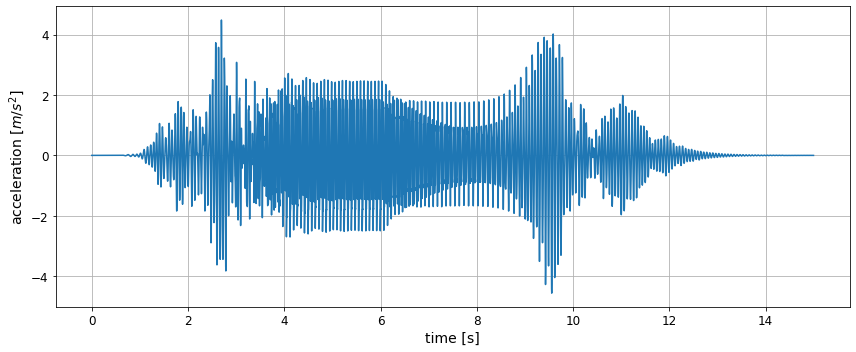

In [22]:
%%time
ti = 0
tf = 15
c = 200
k = 500000
m = 50
h = (tf-ti)/time_steps

t_vals = Runge_kutta(rpm_buildup)[0]
z1_vals = Runge_kutta(rpm_buildup)[1]
z2_vals = Runge_kutta(rpm_buildup)[2]

# print(z2_vals)

F_vec = []
velocity_vec = z2_vals
acceleration_vec = []
t_vec = []
w_vec = [0]
rpm_vec = []
speed_rpm = rpm_buildup

for i in range (1, len(velocity_vec)-1):
    acc = ((velocity_vec[i+1] - velocity_vec[i-1])/(2*h))
    a1,a2,a3 = get_F_response(t_vals[i], speed_rpm,w_vec)
    F_vec.append(a1)
    w_vec.append(a2[0])
    rpm_vec.append(a3[0])
    t_vec.append(t_vals[i])
    acceleration_vec.append(acc)

acceleration_vec = np.array(acceleration_vec)
t_vec = t_vals[:-2]
plt.figure(num=1, figsize=(12,5))
plt.plot(t_vec, acceleration_vec)
#plt.title(r'Acceleration Response - $\ddot{x}(t)$',fontsize=20,y=1.05)
plt.xlabel('time [s]',fontsize = 14)
plt.ylabel('acceleration $[m/s^2]$',fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()
plt.savefig('q1_acc_1.png',dpi=300)



Wall time: 204 ms


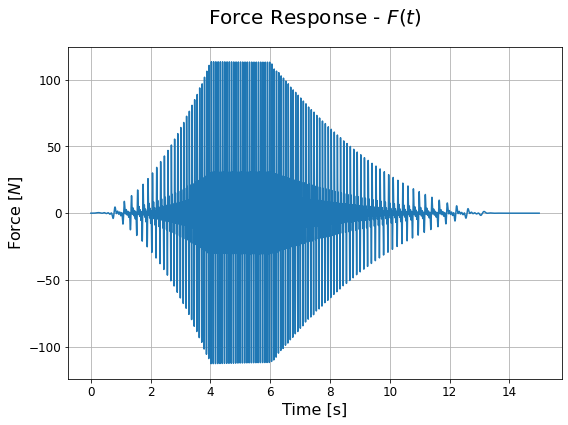

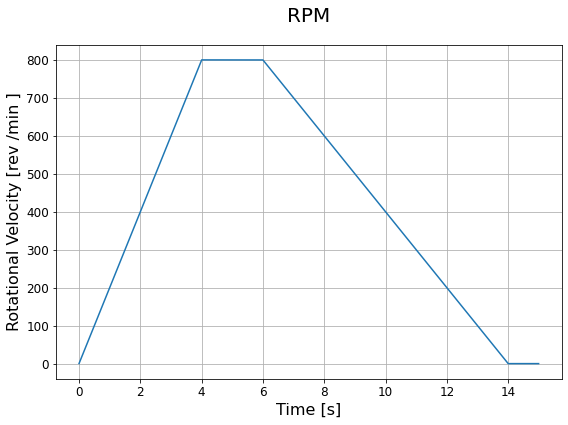

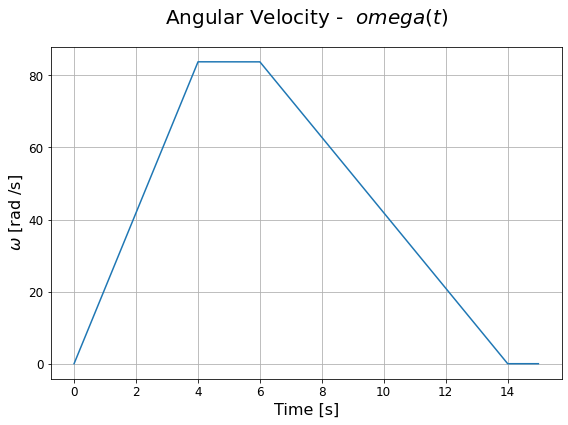

In [7]:
%%time
plt.figure(num=2, figsize=(8,6))
plt.plot(t_vec, F_vec)
plt.title(r'Force Response - $F(t)$',fontsize=20,y=1.05)
plt.xlabel('Time [s]',fontsize = 16)
plt.ylabel('Force $[N]$',fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()

plt.figure(num=3, figsize=(8,6))
plt.plot(t_vec, rpm_vec)
plt.title(r'RPM',fontsize=20,y=1.05)
plt.xlabel('Time [s]',fontsize = 16)
plt.ylabel('Rotational Velocity [rev /min ]',fontsize = 16)
plt.xticks(fontsize =12)
plt.yticks(fontsize =12)
plt.grid()
plt.tight_layout()

plt.figure(num=4, figsize=(8,6))
plt.plot(t_vec, w_vec[:-1])
plt.title(r'Angular Velocity - $\ omega (t)$',fontsize=20,y=1.05)
plt.xlabel('Time [s]',fontsize = 16)
plt.ylabel('$\omega$ [rad /s]',fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()

### Part b)

Wall time: 939 ms


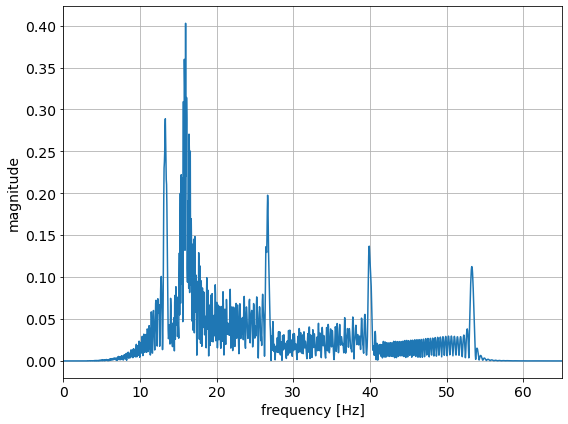

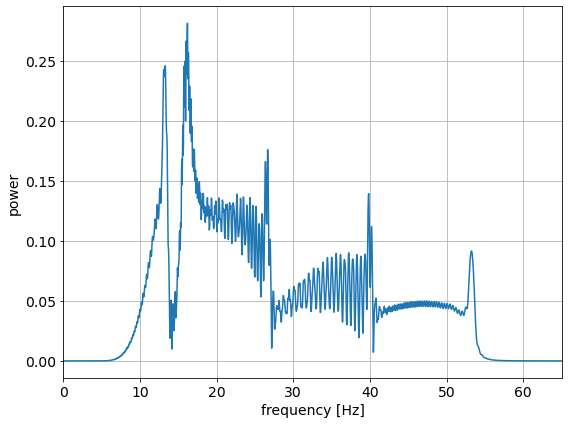

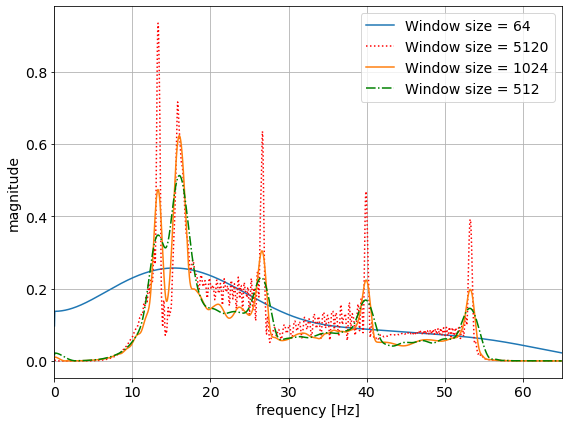

In [98]:
%%time
fs = 1/(t_vec[1] - t_vec[0]) # Sampling Frequency
fn = fs/2 # Nyquist Frequency

acc_sig = acceleration_vec # Signal of Interest
rpm_sig = rpm_vec
w_sig = w_vec

Nfft = 2**nextpow2(len(acc_sig))
fftx = np.fft.fft(acc_sig, Nfft)
Nup = np.ceil((Nfft)/2)
Mx = 2*abs(fftx[0:Nfft//2]/len(time))
f = np.arange(0, Nup)*(2/Nfft)*fn
angle = np.angle(fftx[0:Nfft//2])

plt.figure(num = 7, figsize=(8,6))
plt.plot(f,Mx)
#plt.title('FFT',fontsize = 20, y = 1.05)
plt.xlabel('frequency [Hz]',fontsize = 14)
plt.ylabel('magnitude',fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,65])
plt.grid()
plt.tight_layout()
#plt.savefig('q1_fft.png',dpi=300)


f, Pxx = signal.periodogram(acc_sig, fs ,'flattop', scaling='spectrum', nfft = Nfft)
A_rms = np.sqrt(Pxx)

plt.figure(num = 8, figsize=(8,6))
plt.plot(f, A_rms)
#plt.title('Power Spectral Density Estimation ( PSDe )',fontsize = 20, y = 1.05)
plt.xlabel('frequency [Hz]',fontsize = 14)
plt.ylabel('power',fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,65])
plt.grid()
plt.tight_layout()
plt.savefig('q1_power.png',dpi=300)

window_size = 512
w = signal.get_window('hanning', window_size) # windowing method
nfft = 2**nextpow2(len(acc_sig))

f1, Pxx1 = signal.welch(acc_sig, fs, window = w, nfft = Nfft)
A_rms1 = np.sqrt(Pxx1)
f2, Pxx2 = signal.welch(acc_sig, fs ,window = signal.get_window('hanning',5120), nfft = Nfft)
A_rms2 = np.sqrt(Pxx2)
f3, Pxx3 = signal.welch(acc_sig, fs ,window = signal.get_window('hanning',1024), nfft = Nfft)
A_rms3 = np.sqrt(Pxx3)
f4, Pxx4 = signal.welch(acc_sig, fs ,window = signal.get_window('hanning',64), nfft = Nfft)
A_rms4 = np.sqrt(Pxx4)

plt.figure(num = 9, figsize=(8,6))
plt.plot(f4, A_rms4, label ='Window size = 64')
plt.plot(f2, A_rms2,'r:', label = 'Window size = 5120')
plt.plot(f3, A_rms3, label = 'Window size = 1024')

plt.plot(f1, A_rms1,'g-.', label = 'Window size = 512')
#plt.title('PSDe - Welch',fontsize = 20, y = 1.05)
plt.xlabel('frequency [Hz]',fontsize = 14)
plt.ylabel('magnitude',fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14,loc='best')
plt.xlim([0,65])
plt.grid()
plt.tight_layout()
plt.savefig('q1_welch.png',dpi=300)

### Part c)

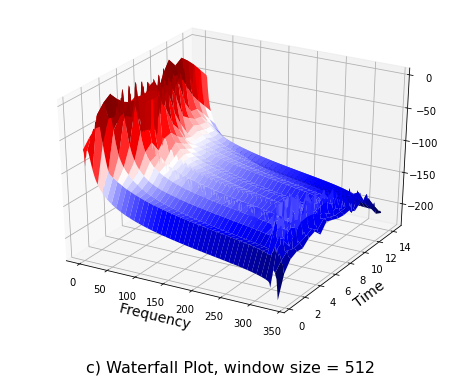

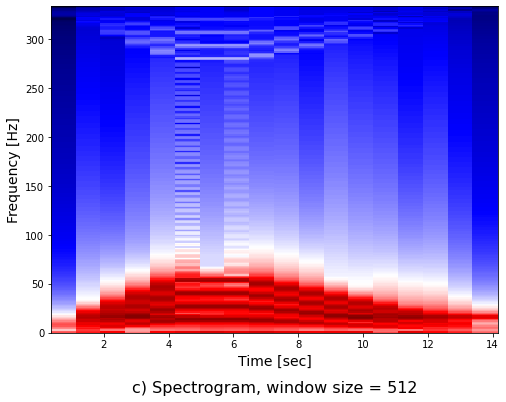

Wall time: 432 ms


In [114]:
%%time

fs = 1/(t_vec[1] - t_vec[0]) # Sampling Frequency
time = t_vec # Time Vector

acc_sig = acceleration_vec # Signal of Interest
rpm_sig = rpm_vec
w_sig = w_vec

window_size = 512# 128, 256, 512
w = signal.get_window('hanning',window_size) # windowing method
nfft = 2**nextpow2(len(acc_sig))
nperseg = window_size
noverlap = 2
f, t, Sxx = spectrogram(x = acc_sig, fs = fs, window = w, noverlap = noverlap, nperseg = nperseg)

fig = plt.figure(num = 5, figsize=(8,6))
ax = fig.gca(projection ='3d')
ax.plot_surface(f[:, None], t[None, :], 10.0*np.log10(Sxx), cmap =cm.seismic)
plt.title('c) Waterfall Plot, window size = {}'.format(window_size),fontsize=16 , y = -0.15)
plt.ylabel('Time ',fontsize=14)
plt.xlabel('Frequency ',fontsize=14)
#plt.savefig('q1_waterfall.png',dpi=300)

plt.figure(num = 6, figsize=(8,6))
plt.pcolormesh(t, f, 10.0*np. log10(Sxx),cmap =cm.seismic)
plt.title('c) Spectrogram, window size = {}'.format(window_size),fontsize=16,y = -0.2)
plt.ylabel('Frequency [Hz]',fontsize=14)
plt.xlabel('Time [sec]',fontsize=14)
#plt.savefig('q1_spectrogram.png',dpi=300)
plt.show()

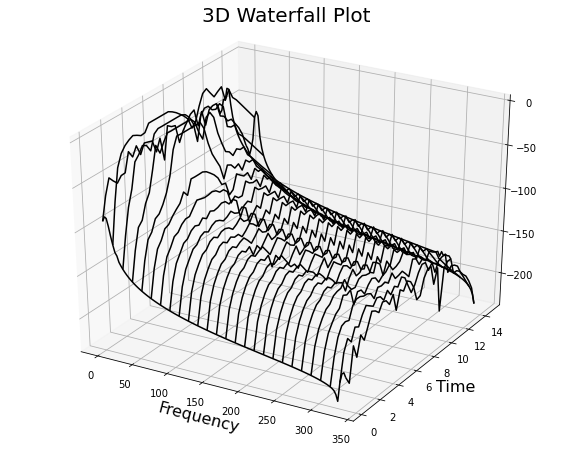

Wall time: 161 ms


In [10]:
%%time

fig1 = plt.figure(num=7, figsize=(10,8))
ax1 = fig1.gca(projection='3d')
#plt.title('3D Waterfall Plot',fontsize=20,y = 1.05)
plt.ylabel('Time',fontsize=14)
plt.xlabel('Frequency',fontsize=14)

ax1.plot_wireframe(f[:, None], t[None, :], 10.0*np.log10(Sxx), color='k', rstride=5, cstride=30)
plt.savefig('q1_welch.png',dpi=300)
plt.show()

Wall time: 2min 38s


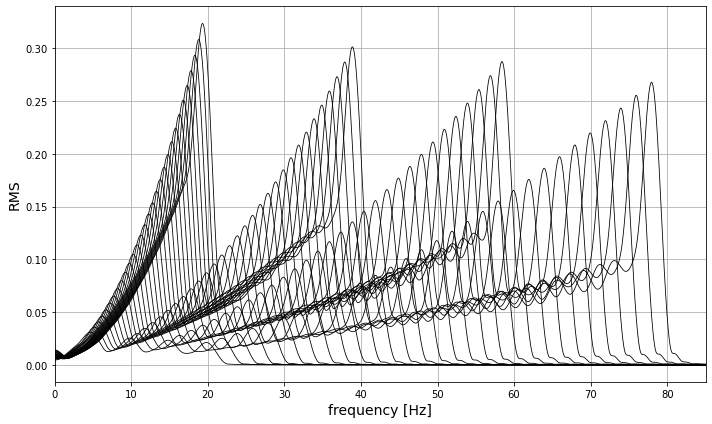

In [90]:
%%time
import scipy.signal as signal

plt.figure(num=1, figsize=(10,6))
#plt.title('Cascade Plot varying RPM', fontsize=20, y=1.05)

for i in range(300, 1200, 30): 

    acc_vec = []
    t_vec = []  
    vel = Runge_kutta(i)[2]

#     print(vel[5000:5010])
    
    for j in range(1, len(vel)-1):
        acc = ((vel[j+1] - vel[j-1])/(2*h))

        acc_vec.append(acc)
        t_vec.append(t_vals[j])
        
    acc_vec = np.array(acc_vec)
    t_vec = np.array(t_vec)

    f, Pxx = signal.welch(acc_vec, fs, window = w, nfft = Nfft)
    A_rms = np.sqrt(Pxx)
    new_A_rms = []
    for k in range(len(A_rms)):
        aa = A_rms[k]
        new_A_rms.append(aa)

    plt.plot(f, new_A_rms, 'k-', linewidth = 0.8)
    plt.xlim([0,85])
    
plt.xlabel('frequency [Hz]', fontsize=14)
plt.ylabel('RMS', fontsize=14)
plt.grid()
plt.tight_layout()
plt.savefig('q1_cascade.png',dpi=300)

In [63]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal as scisig
from scipy.signal import filtfilt, square, butter
from scipy.interpolate import interp1d


In [79]:
%%time
def ang_velocity(t):
    y = np.zeros(len(t))
    for i,s in zip(t, range(len(t))):
        if i < 4:
            y[s] = 200*i
        if i >= 4 and i < 6:
            y[s] = 800
        if i >= 6 and i < 14:
            y[s] = -100*i + 1400
        if i >= 14:
            y[s] = 0.001 # 0 results in numerical error...
    return y*(2*np.pi/60) # Therefore, in radians per second...

length = 1500  # 1500, 1400 
t = np.linspace(0, 15, length)  # 15, 14
signal = np.zeros(2*length*10000) # 2*length*1000
my_func = ang_velocity(t) * 1000 / max(ang_velocity(t))

# plt.plot(t, my_func)
# plt.show()

for i,j in zip(my_func[1:-1],range(1500)):             
    eppr = 0.5 # encoder pulses per revolution, correction
    interval = scisig.unit_impulse(20000, np.arange(0, 20000, int(20000/(i*eppr))))[1:]
    signal[j*20000:(j+1)*20000] = np.append(0, interval)

counter = 0
for i in range(len(signal)):
    if signal[i] == 1:
        signal[i-1] = 1
        signal[i-2] = 1
        signal[i-3] = 1 
        signal[i-4] = 1
        signal[i-5] = 1
        signal[i-6] = 1 
        signal[i-7] = 1
        signal[i-8] = 1
        signal[i-9] = 1 
        counter += 1

print(signal.shape)

# -----
# eppr = 0.5: 500 pulses per rev
# eppr = 1: 1000 pulses per rev
# eppr = 2: 2000 pulses per rev

# Should see that the lower the pulses per revolution, the more noise is inherent in the solution. 

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\scipy\signal\waveforms.py:675: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif idx == 'mid':


(30000000,)
Wall time: 14.5 s


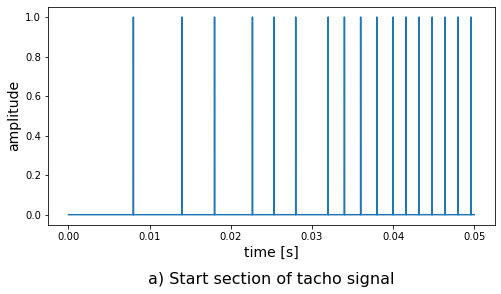

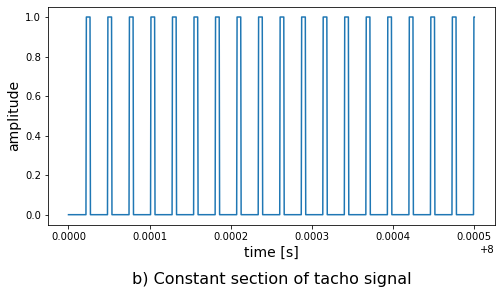

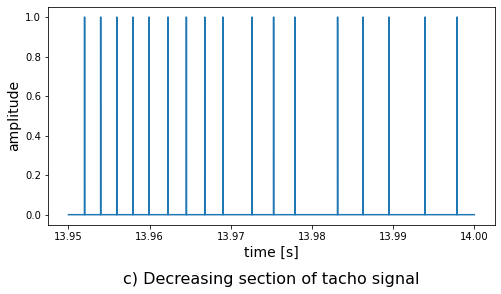

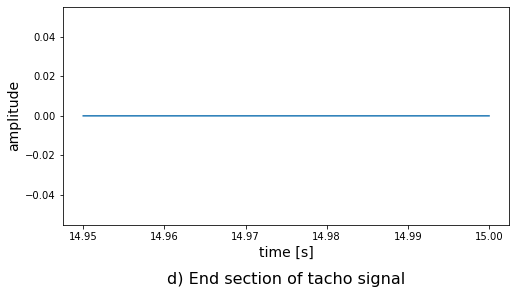

In [87]:
# ADD FIGURES OF TACHO SIGNAL SECTIONS...
plt.figure(1, figsize=(8,4))
t = np.linspace(0, 0.05, 100000)
plt.plot(t, signal[0:100000])
plt.title('a) Start section of tacho signal', y=-0.3,size=16)
plt.ylabel('amplitude',size=14)
plt.xlabel('time [s]',size=14)
plt.show()

plt.figure(2, figsize=(8,4))
t = np.linspace(8, 8.0005, 1000)
plt.plot(t, signal[16000000:16001000])
plt.title('b) Constant section of tacho signal', y=-0.3,size=16)
plt.ylabel('amplitude',size=14)
plt.xlabel('time [s]',size=14)
plt.show()

plt.figure(3, figsize=(8,4))
t = np.linspace(13.95, 14, 100000)
plt.plot(t, signal[27800000:27900000])
plt.title('c) Decreasing section of tacho signal', y=-0.3,size=16)
plt.ylabel('amplitude',size=14)
plt.xlabel('time [s]',size=14)
plt.show()

plt.figure(4, figsize=(8,4))
t = np.linspace(14.95, 15, 100000)
plt.plot(t, signal[28900000:29000000])
plt.title('d) End section of tacho signal', y=-0.3,size=16)
plt.ylabel('amplitude',size=14)
plt.xlabel('time [s]',size=14)
plt.show()




10.714285714285714
14.999999


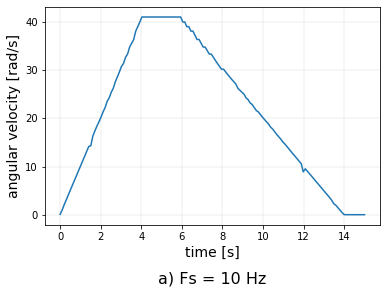

107.14285714285714
14.999999


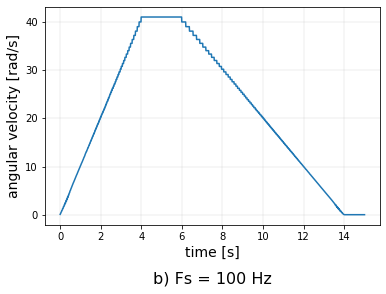

1071.4285714285713
14.999999


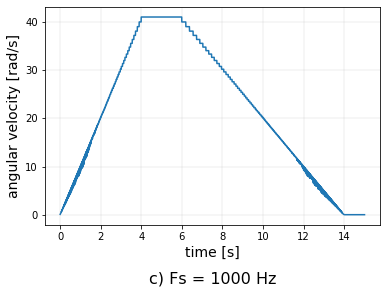

10714.285714285714
14.999999


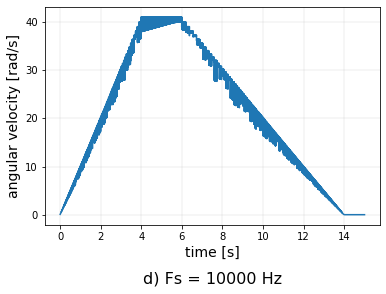

Wall time: 31.5 s


In [75]:
%%time
def maketime(x, fs):
    t = np.arange(0, len(x))/fs
    return t


#                                       pulses per revolution for tacho 
def getrpm(tacho, fs, triglevel, slope, ppr, newfs):
    y = np.sign(tacho - triglevel)
    dy = np.diff(y)
    tt = maketime(dy, fs)
    
    if slope > 0:
        yt = tt[np.where(dy > 0.8)] 
    if slope < 0:
        yt = tt[np.where(dy < 0.8)]
    dy = np.diff(yt)
    dy = np.append(dy, dy[-1])
    
    rpm = 60/ppr*np.ones(dy.shape)/dy
    b = np.array([0.25, 0.5, 0.25])
    a = 1
#     b, a = butter(8, 0.125)
    rpm = filtfilt(b, a, rpm)
    
    N = max(tt)*newfs/200 + 1
    trpm = np.linspace(0, max(tt), int(N))
    trpm = trpm.reshape(-1, 1)
    f = interp1d(yt, rpm, axis = 0, fill_value = "extrapolate")
    rpm = f(trpm)
    
    return rpm/375, trpm/200 # Changed to represent plot       rpm/100

f=lambda a: (abs(a)+a)/2
for freq,nrs in zip([10, 100, 1000, 10000],['a) ','b) ','c) ','d) ']):
    #                                  How many points per second (freq)
    sig = getrpm(signal, 10000, 1, 1, 1, freq)
    print(len(sig[0])/14)
    print(np.max(sig[1]))
    plt.plot(sig[1], f(np.array(sig[0])))
    plt.title(nrs+'Fs = {} Hz'.format(freq), y=-0.3,size=16)
    plt.ylabel('angular velocity [rad/s]',size=14)
    plt.xlabel('time [s]',size=14)
    plt.grid(linewidth = 0.2)
    plt.show()

